## Goal of Analysis:

### 1. What percentage of users opened the email and what percentage clicked on the link within the email

### 2. build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email

### 3. By how much do you think your model would improve click through rate ( defined as # of users who click on the link / total users who received the email). How would you test that?

### 4. Did you find any interesting pattern on how the email campaign performed for different segments of users? Explain

In [1]:
import numpy as np
import pandas as pd

In [2]:
email_opened_table = pd.read_csv('email_opened_table.csv')
email_opened_table.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [3]:
email_table = pd.read_csv('email_table.csv')
email_table.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [4]:
link_clicked_table = pd.read_csv('link_clicked_table.csv')
link_clicked_table.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


In [5]:
email_opened_table.shape, email_table.shape, link_clicked_table.shape

((10345, 1), (100000, 7), (2119, 1))

## Part 1: Data Preprocessing

#### First, I will add a column to indicate those IDs are marked as open or click

In [6]:
email_opened_table['email_open'] = '1'
email_opened_table.head()

,email_id,email_open
0,284534,1
1,609056,1
2,220820,1
3,905936,1
4,164034,1


In [7]:
link_clicked_table['link_click'] = '1'
link_clicked_table.head()

,email_id,link_click
0,609056,1
1,870980,1
2,935124,1
3,158501,1
4,177561,1


#### Next, merge three tables together

In [8]:
data = pd.merge(left = email_table, right = email_opened_table, on = 'email_id', how = 'left')
full_data = pd.merge(left = data, right = link_clicked_table, on = 'email_id', how = 'left')
full_data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
0,85120,short_email,personalized,2,Sunday,US,5,NaN,NaN
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,NaN,NaN
3,493711,short_email,generic,6,Monday,UK,1,NaN,NaN
4,106887,long_email,generic,14,Monday,US,6,NaN,NaN


#### in this dataset, the null value means those email_id has not open the email or click the link within the emal

## Part 2: calculate % of users opened the email and % clicked on the link

In [9]:
email_open_rate = 1-(full_data['email_open'].isnull().sum() / len(full_data))

print('{percent:.2%}'.format(percent=email_open_rate))

10.35%


In [10]:
link_click_rate = 1-(full_data['link_click'].isnull().sum() / len(full_data))

print('{percent:.2%}'.format(percent=link_click_rate))

2.12%


#### Since the email open rate and link click rate are both quite low, I also want to know, the % of people click the link among the people who open the email

In [11]:
link_click_when_open = full_data[~full_data['email_open'].isnull()]

In [12]:
link_click_rate_on_open = 1-(link_click_when_open['link_click'].isnull().sum() / len(link_click_when_open))

print('{percent:.2%}'.format(percent=link_click_rate_on_open))

20.00%


#### within the people who open the email, around 20% of them click the link, not that bad

## Part 3: build a model to maximize the probability of users clicking the link

In [13]:
full_data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
0,85120,short_email,personalized,2,Sunday,US,5,NaN,NaN
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,NaN,NaN
3,493711,short_email,generic,6,Monday,UK,1,NaN,NaN
4,106887,long_email,generic,14,Monday,US,6,NaN,NaN


#### first, let me check how many unique values in each columns to see what feature engineering I can do

In [14]:
full_data.nunique()

email_id               100000
email_text                  2
email_version               2
hour                       24
weekday                     7
user_country                4
user_past_purchases        23
email_open                  1
link_click                  1
dtype: int64

In [15]:
full_data.email_text.unique()

array(['short_email', 'long_email'], dtype=object)

In [16]:
full_data.email_version.unique()

array(['personalized', 'generic'], dtype=object)

In [17]:
full_data.isna().sum()

email_id                   0
email_text                 0
email_version              0
hour                       0
weekday                    0
user_country               0
user_past_purchases        0
email_open             89655
link_click             97881
dtype: int64

#### we need to find out what features contribte most to clicking the link, so I plan to use decision tree model

I first replace all the null value in email_open and linl_click as 0

In [18]:
full_data = full_data.fillna(0)

In [19]:
full_data.isna().sum()

email_id               0
email_text             0
email_version          0
hour                   0
weekday                0
user_country           0
user_past_purchases    0
email_open             0
link_click             0
dtype: int64

In [20]:
full_data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


In [21]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [22]:
email_text_label = le.fit_transform(full_data['email_text'])
email_version_label = le.fit_transform(full_data['email_version'])
weekday_label = le.fit_transform(full_data['weekday'])
user_country_label = le.fit_transform(full_data['user_country'])

In [23]:
import warnings
warnings.filterwarnings('ignore')

label_data = pd.DataFrame()
label_data['email_id'] = full_data['email_id']
label_data['email_text'] = email_text_label
label_data['email_version'] = email_version_label
label_data['hour'] = full_data['hour']
label_data['weekday'] = weekday_label
label_data['user_country'] = user_country_label
label_data['user_past_purchases'] = full_data['user_past_purchases']
label_data['email_open'] = full_data['email_open'].astype('int')
label_data['link_click'] = full_data['link_click'].astype('int')
label_data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
0,85120,1,1,2,3,3,5,0,0
1,966622,0,1,12,3,2,2,1,1
2,777221,0,1,11,6,3,2,0,0
3,493711,1,0,6,1,2,1,0,0
4,106887,0,0,14,1,3,6,0,0


#### fit a decision tree model to see the featue importance

In [24]:
X = label_data.drop(['email_id', 'link_click', 'email_open'], axis=1)
Y = label_data['link_click'].astype('int')

In [25]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

In [26]:
clf.feature_importances_

array([0.1012786 , 0.01524751, 0.33280846, 0.19217639, 0.12199782,
       0.23649123])

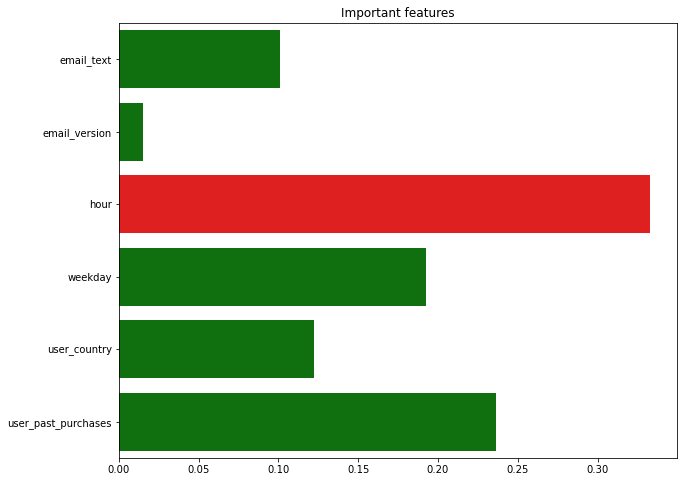

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

values = clf.feature_importances_  
idx = clf.feature_names_in_
plt.figure(figsize=(10,8))
clrs = ['green' if (x < max(values)) else 'red' for x in values ]
sns.barplot(y=idx,x=values,palette=clrs).set(title='Important features')
plt.show()

In [28]:
y_predict = clf.predict(X)
y_predict

array([0, 0, 0, ..., 0, 0, 0])

In [29]:
from sklearn.metrics import classification_report, precision_score,recall_score

print("The precision for Tree is ",precision_score(Y, y_predict)) 
print("The recall for Tree is ",recall_score(Y, y_predict),"\n") 

The precision for Tree is  0.9700374531835206
The recall for Tree is  0.12222746578574799 



#### Apparently, hour, and user past purchases are the most important three factors that contributed to link clicking

## Part 4: factors relating to the click improve

#### Next, I will also visualize the click vs email text and email version to see if there is any connections

In [30]:
full_data.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,email_open,link_click
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


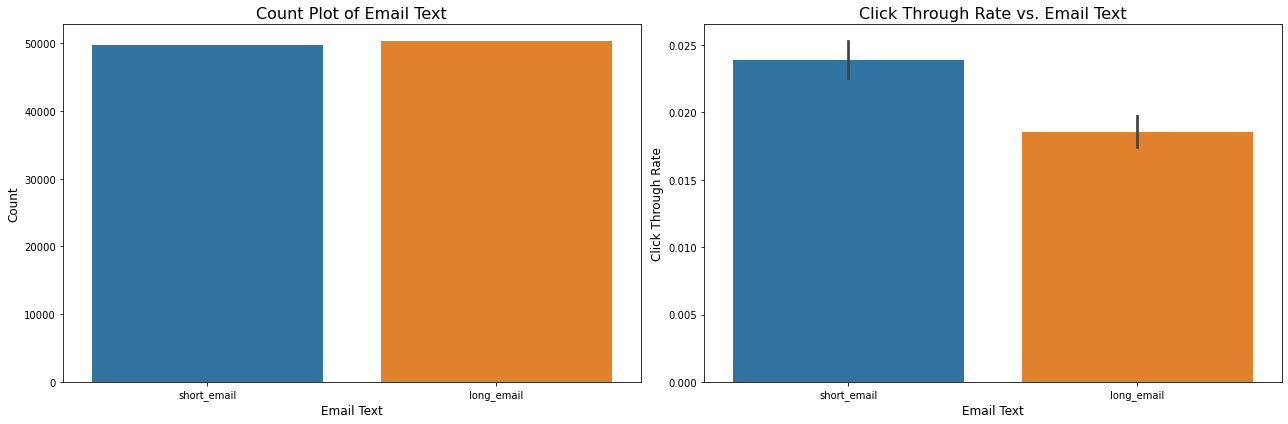

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_text', data=full_data, ax=ax[0])
ax[0].set_xlabel('Email Text', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Text', fontsize=16)

sns.barplot(x='email_text', y=full_data['link_click'].astype('float'), data=full_data, ax=ax[1])
ax[1].set_xlabel('Email Text', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Text', fontsize=16)
plt.tight_layout()
plt.show()

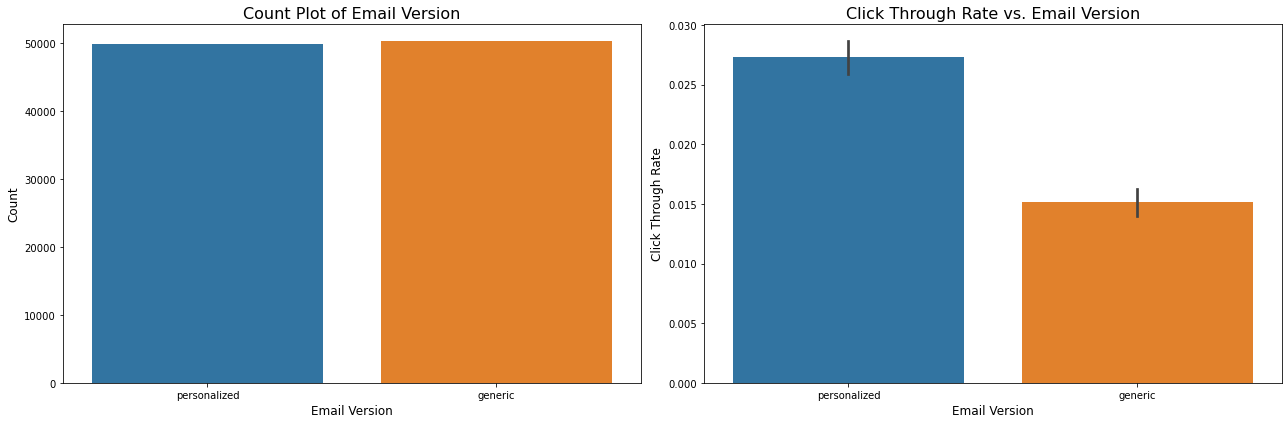

In [32]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='email_version', data=full_data, ax=ax[0])
ax[0].set_xlabel('Email Version', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Version', fontsize=16)

sns.barplot(x='email_version', y=full_data['link_click'].astype('float'), data=full_data, ax=ax[1])
ax[1].set_xlabel('Email Version', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Version', fontsize=16)
plt.tight_layout()
plt.show()

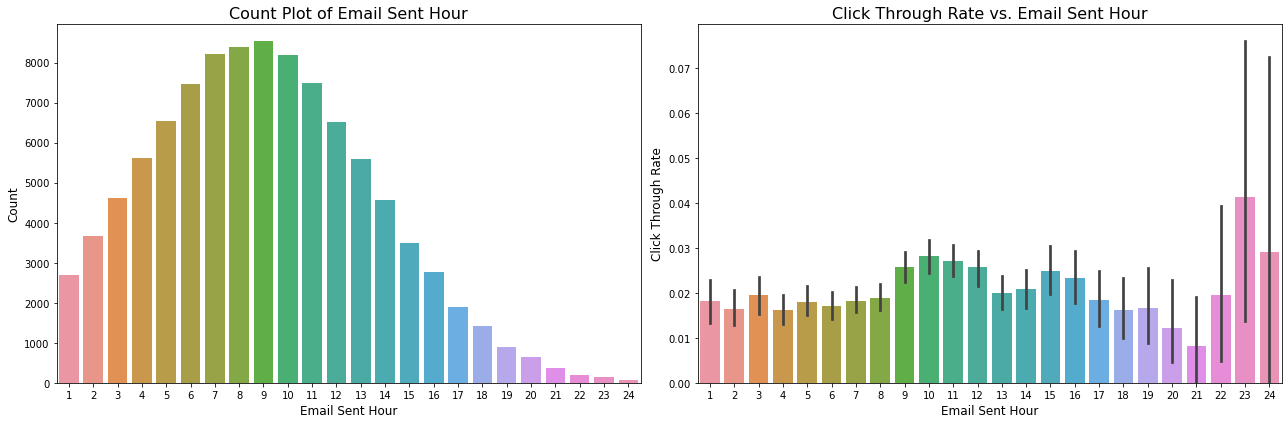

In [33]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='hour', data=full_data, ax=ax[0])
ax[0].set_xlabel('Email Sent Hour', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Hour', fontsize=16)

sns.barplot(x='hour', y=full_data['link_click'].astype('float'), data=full_data, ax=ax[1])
ax[1].set_xlabel('Email Sent Hour', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Hour', fontsize=16)
plt.tight_layout()
plt.show()

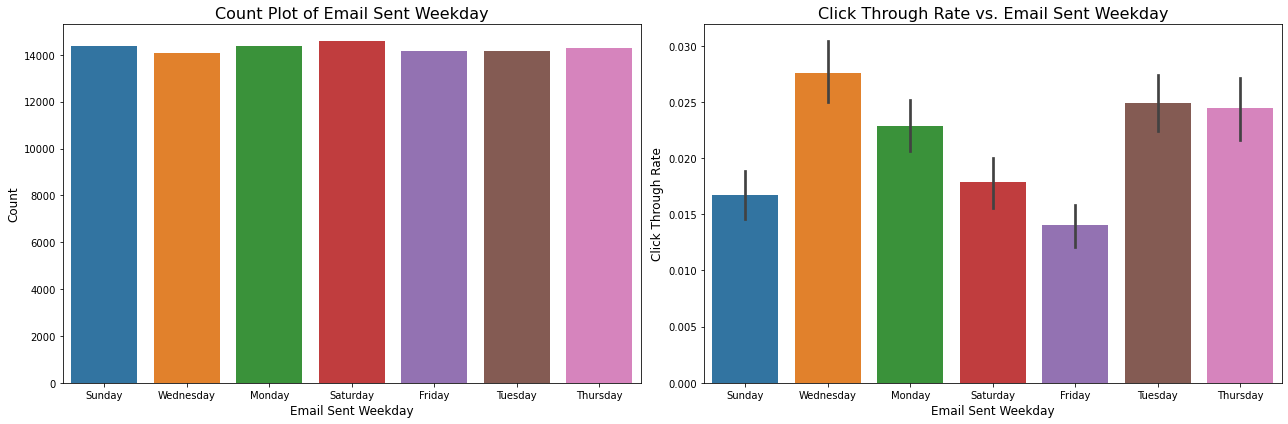

In [34]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='weekday', data=data, ax=ax[0])
ax[0].set_xlabel('Email Sent Weekday', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of Email Sent Weekday', fontsize=16)

sns.barplot(x='weekday', y=full_data['link_click'].astype('float'), data=full_data, ax=ax[1])
ax[1].set_xlabel('Email Sent Weekday', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. Email Sent Weekday', fontsize=16)
plt.tight_layout()
plt.show()

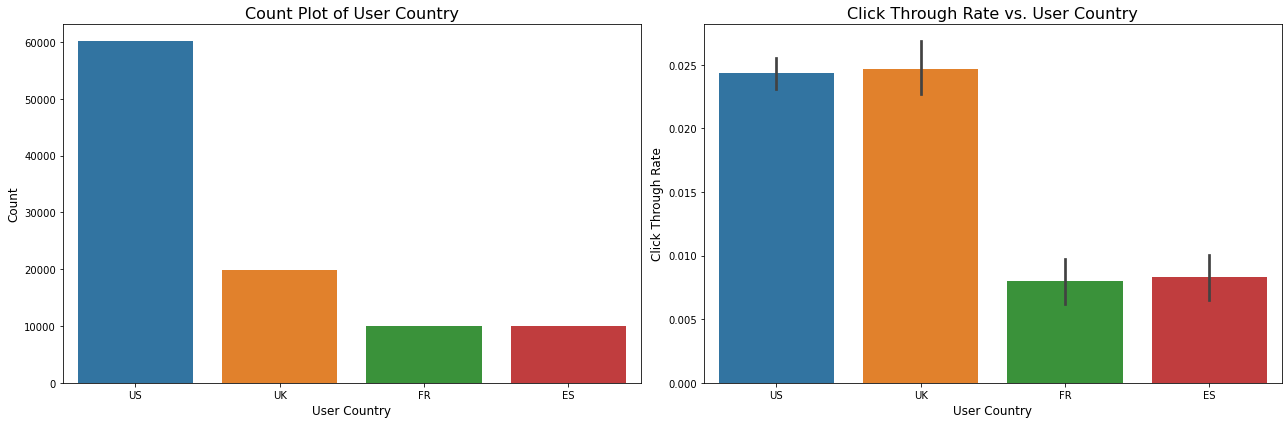

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_country', data=full_data, ax=ax[0])
ax[0].set_xlabel('User Country', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Country', fontsize=16)

sns.barplot(x='user_country', y=full_data['link_click'].astype('float'), data=full_data, ax=ax[1])
ax[1].set_xlabel('User Country', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Country', fontsize=16)
plt.tight_layout()
plt.show()

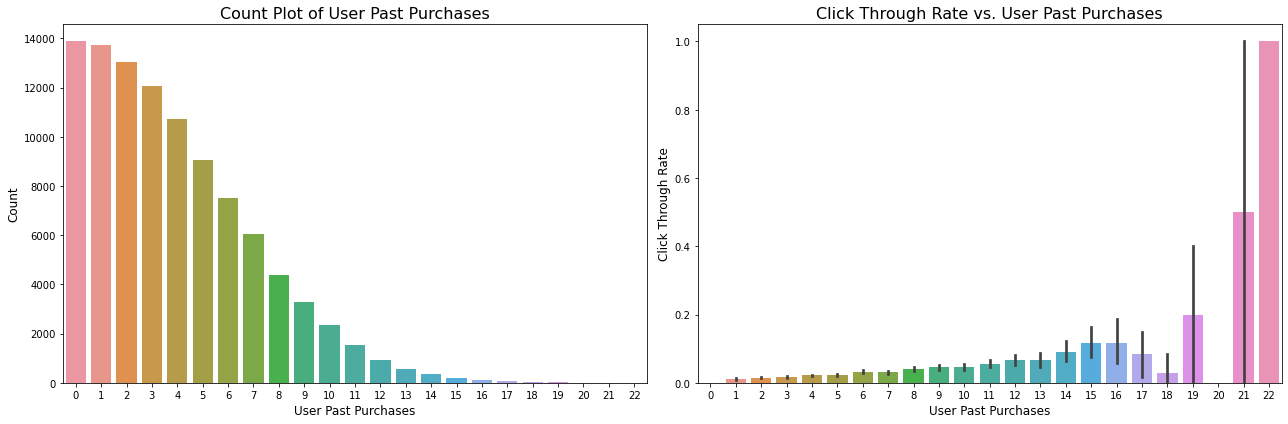

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.countplot(x='user_past_purchases', data=full_data, ax=ax[0])
ax[0].set_xlabel('User Past Purchases', fontsize=12)
ax[0].set_ylabel('Count', fontsize=12)
ax[0].set_title('Count Plot of User Past Purchases', fontsize=16)

sns.barplot(x='user_past_purchases', y=full_data['link_click'].astype('float'), data=full_data, ax=ax[1])
ax[1].set_xlabel('User Past Purchases', fontsize=12)
ax[1].set_ylabel('Click Through Rate', fontsize=12)
ax[1].set_title('Click Through Rate vs. User Past Purchases', fontsize=16)
plt.tight_layout()
plt.show()

#### Base on the above analysis, company can choose to make modification on the following areas:

#### 1. send short emails with personalized contents

#### 2. send them during the first half (Monday - Wednesday) and late of the night (10PM -12AM)

#### 3. the company can also conduct A/B testing to test if the situation is true as the above analysis: send the old version emails to all users in control group, then send the modified version in test group